In [1]:
# -*- coding: utf-8 -*-
# Pyomo + Gurobi: Lagrangean-based (per Karuppiah & Grossmann, 2008) – single-node loop
from dataclasses import dataclass, field
from typing import Callable, List, Dict, Tuple
import math

from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

from typing import List, Dict

In [10]:
solver = SolverFactory('gurobi')
solver.options.update({
    'MIPGap': 1e-8,         
    'MIPGapAbs': 0.0,       
    'FeasibilityTol': 1e-9,  
    'IntFeasTol':     1e-9,  
    'OptimalityTol': 1e-9,
    'NumericFocus': 2,      
    'ScaleFlag':    1,       
    'Presolve': 2,          
    'Method':  -1,          
    'Crossover': -1,       
    'NonConvex': 2, 
})

In [2]:
solver = SolverFactory('ipopt',executable=r"C:\Users\pc\miniconda3\Library\bin\ipopt.exe")
solver.options.update({
    "max_iter": 20000,          
    "tol": 1e-8,                
    "constr_viol_tol": 1e-8,    
    "acceptable_tol": 1e-6,    
    "acceptable_iter": 10,
    "mu_strategy": "adaptive",  
    "linear_solver": "mumps",  
})

In [11]:
 # ========== Solve Lagrangian relaxation once ==========
def solve_lagrangian_once(model_list: List[ConcreteModel], lambdas: List[float]):
    xs, objs = [], []
    N = len(model_list)
    for n, m in enumerate(model_list):
        if hasattr(m, 'obj'):
            m.del_component(m.obj)
        lag_term = (lambdas[n+1]-lambdas[n]) * m.y
        m.obj = Objective(expr = m.obj_expr + lag_term, sense=minimize)
        solver.solve(m, tee=False)
        xs.append(value(m.y))
        objs.append(value(m.obj))
    return xs, objs, sum(objs)

# ========== subgradient lambda update ==========
def subgradient_update(
    lambdas: list[float],
    xs: list[float],                       
    zUB: float,
    zLB: float,
    alpha_fac: float = 0.5           
) -> list[float]:
    """
    g_n = x^n - x^{n+1},  n=1,...,N-1
    t = α * (zUB - zLB) / ||g||^2
    """
    N = len(xs)
    g = [xs[n] - xs[n+1] for n in range(N-1)]
    g2 = sum(gi*gi for gi in g)
    if g2 <= 1e-16:
        return lambdas[:]
    t = alpha_fac * max(0.0, zUB - zLB) / g2
    
    new_lambdas = [0]
    for i, lam in enumerate(lambdas):
        if 1<=i<=(N-1):
            new_lambdas.append(lam + t * g[i-1]) 
    new_lambdas.append(0)
    '''
    new_lambdas = lambdas
    new_lambdas[1] = lambdas[1] + t * g[0]
    '''
    print('zUB is ',zUB)
    print('zLB is ',zLB)
    print('g2 is ',g2)
    return new_lambdas

# ========== evaluate upper bound ==========
def compute_upper_bound(
    model_list: List[ConcreteModel],
    xs: list
) -> float:
    """
    use mean value of xs to evaluate a upper bound
    """
    x_bar = np.mean(xs)
    print('x_bar is ',x_bar)
    objss = []
    N = len(model_list)
    for n, m in enumerate(model_list):
        if hasattr(m, 'obj'):
            m.del_component(m.obj)
        m.obj = Objective(expr = m.obj_expr, sense=minimize)
        m.y.fix(x_bar)
        solver.solve(m, tee=False)
        objss.append(value(m.obj))
        m.y.unfix()
    zUB = sum(objss)
    return zUB

# ========== main loop ==========
def lagrangian_loop(model_list: List[ConcreteModel],
                    max_iter: int = 20,
                    alpha_fac: float = 0.5,
                    lam0: List[float] = None):
    N = len(model_list)
    lambdas = lam0 if lam0 is not None else [0.0]*(N+1)
    history = []
    for k in range(max_iter):
        print('=====')
        xs, objs, zLB = solve_lagrangian_once(model_list, lambdas)
        zUB = compute_upper_bound(model_list,xs)
        history.append((k, zLB, xs, lambdas[:]))
        lambdas = subgradient_update(lambdas, xs, zUB, zLB, alpha_fac)
        print(f"iter {k:02d}: zLB={zLB:.6f}, xs={['%.4f'%x for x in xs]}, λ={['%.3f'%l for l in lambdas]}")
        print('objs is ',objs)
        print('lower bound is ',sum(objs))
    return history

In [12]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return np.sqrt(np.abs(y))

v_list = [v_1, v_2]

# lower bound and upper bound
ylb = -0.2
yub = 0.2
bounds = [ylb, yub]
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(ylb, yub))
m2.x2 = Var(bounds=(0, 1))
m2.c1 = Constraint(expr=m2.x2**2 >= m2.y)
m2.c2 = Constraint(expr=m2.x2**2 >= -m2.y)
m2.obj_expr = Expression(expr=m2.x2)

model_list = [m1, m2]


lam0 = [0,0.2,0]
max_iter = 20
lag_history = lagrangian_loop(model_list, max_iter=max_iter, alpha_fac=0.5, lam0=lam0)
lag_iter = range(max_iter)
lag_min = [lag_history[i][1] for i in range(len(lag_history))]
# plot
true_min_val = 0

=====
x_bar is  -0.1
zUB is  0.0
zLB is  -0.4872135954999579
g2 is  0.04000000000000001
iter 00: zLB=-0.487214, xs=['-0.2000', '0.0000'], λ=['0.000', '-1.018', '0.000']
objs is  [-0.4872135954999579, 0.0]
lower bound is  -0.4872135954999579
=====
x_bar is  0.09999999883268919
zUB is  0.0
zLB is  -0.6508203882654544
g2 is  0.03999999906615136
iter 01: zLB=-0.650820, xs=['0.2000', '0.0000'], λ=['0.000', '0.609', '0.000']
objs is  [-0.6508203882654544, 0.0]
lower bound is  -0.6508203882654544
=====
x_bar is  -0.09999999855286165
zUB is  0.0
zLB is  -0.5690169906861936
g2 is  0.03999999884228933
iter 02: zLB=-0.569017, xs=['-0.2000', '0.0000'], λ=['0.000', '-0.814', '0.000']
objs is  [-0.5690169906861936, 0.0]
lower bound is  -0.5690169906861936
=====
x_bar is  0.09999999870771507
zUB is  0.0
zLB is  -0.6099186897897418
g2 is  0.03999999896617207
iter 03: zLB=-0.609919, xs=['0.2000', '0.0000'], λ=['0.000', '0.711', '0.000']
objs is  [-0.6099186897897418, 0.0]
lower bound is  -0.60991868978

C:\Users\pc\AppData\Local\Temp\ipykernel_8760\3552828191.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


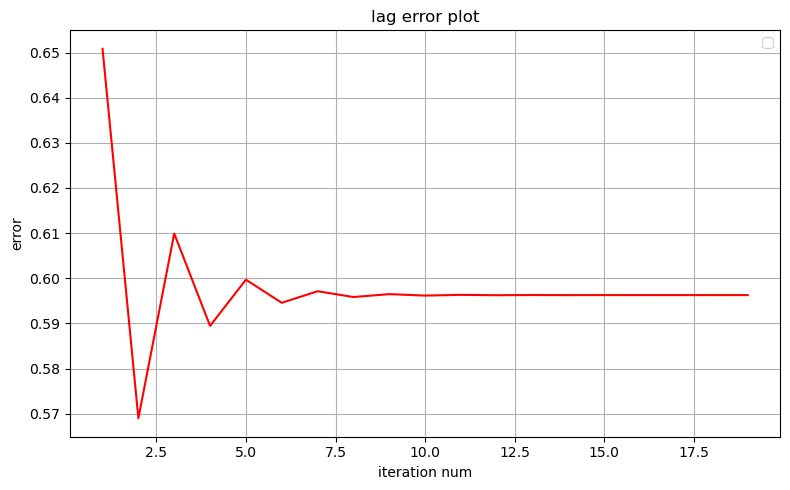

      adds     errors
----------------------
         0 0.487213595500
         1 0.650820388265
         2 0.569016990686
         3 0.609918689790
         4 0.589467840064
         5 0.599693265009
         6 0.594580552494
         7 0.597136908773
         8 0.595858730623
         9 0.596497819703
        10 0.596178275160
        11 0.596338047433
        12 0.596258161296
        13 0.596298104365
        14 0.596278132830
        15 0.596288118598
        16 0.596283125714
        17 0.596285622156
        18 0.596284373935
        19 0.596284998046


In [13]:
plt.figure(figsize=(8, 5))
lag_errors = [true_min_val-item for item in lag_min]
plt.plot(lag_iter[1:], lag_errors[1:], color='red')
plt.xlabel('iteration num')
plt.ylabel('error')
plt.title(f"lag error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'adds':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(lag_iter, lag_errors):
    print(f"{a:>10} {e:>10.12f}")

=====
x_bar is  -0.25
iter 00: zLB=-0.600000, xs=['-0.5000', '0.0000'], λ=['0.000', '0.000', '0.000']
objs is  [-0.65, 0.04999999999999999]
lower bound is  -0.6000000000000001
zUB is  0.03749999999999998
zLB is  -0.6000000000000001
g2 is  0.25
=====
x_bar is  -0.25
iter 01: zLB=-0.281250, xs=['-0.5000', '0.0000'], λ=['0.000', '-0.638', '0.000']
objs is  [-0.33125, 0.04999999999999999]
lower bound is  -0.28125
zUB is  0.03749999999999998
zLB is  -0.28125
g2 is  0.25
=====
x_bar is  -0.25
iter 02: zLB=-0.121875, xs=['-0.5000', '0.0000'], λ=['0.000', '-0.956', '0.000']
objs is  [-0.171875, 0.04999999999999999]
lower bound is  -0.12187500000000001
zUB is  0.03749999999999998
zLB is  -0.12187500000000001
g2 is  0.25
=====
x_bar is  -0.27890625
iter 03: zLB=-0.045530, xs=['-0.5000', '-0.0578'], λ=['0.000', '-1.116', '0.000']
objs is  [-0.09218749999999998, 0.04665771484374999]
lower bound is  -0.04552978515624999
zUB is  0.04411682128906247
zLB is  -0.04552978515624999
g2 is  0.1955297851562

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


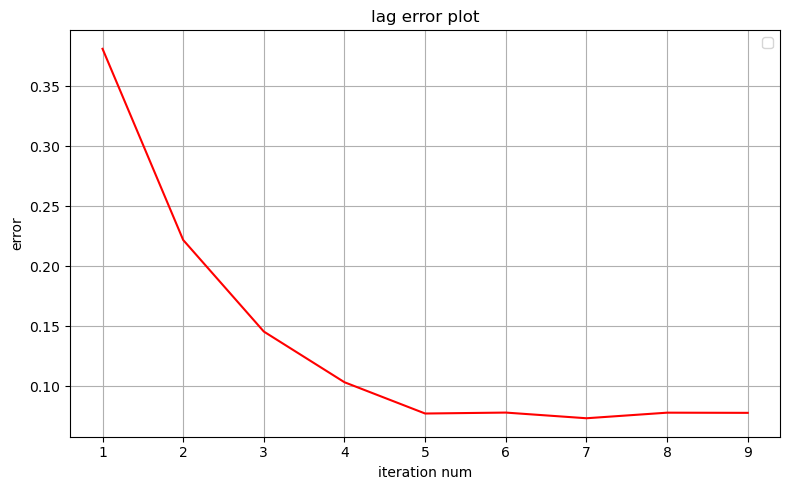

      adds     errors
----------------------
         0 0.700000000000
         1 0.381250000000
         2 0.221875000000
         3 0.145529785156
         4 0.103275308609
         5 0.077205596305
         6 0.077988280123
         7 0.073261336152
         8 0.077909792911
         9 0.077761961030
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: D:\Anaconda

  added / updated specs:
    - ipopt
    - pyomo


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _anaconda_depends-2022.10  |           py39_2          68 KB
    anaconda-custom            |           py39_5           9 KB
    anaconda-anon-usage-0.7.2  |   py39h8ddfbff_0  


The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda==2022.10=py39_0
  - defaults/win-64::anaconda-navigator==2.3.2=py39haa95532_0
  - defaults/win-64::astropy==5.1=py39h080aedc_0
  - defaults/win-64::bkcharts==0.2=py39haa95532_1
  - defaults/win-64::bokeh==2.4.3=py39haa95532_0
  - defaults/win-64::bottleneck==1.3.5=py39h080aedc_0
  - defaults/win-64::daal4py==2021.6.0=py39h757b272_1
  - defaults/win-64::dask==2022.7.0=py39haa95532_0
  - defaults/win-64::datashader==0.14.1=py39haa95532_0
  - defaults/win-64::datashape==0.5.4=py39haa95532_1
  - defaults/win-64::gensim==4.1.2=py39hd77b12b_0
  - defaults/win-64::h5py==3.7.0=py39h3de5c98_0
  - defaults/win-64::holoviews==1.15.0=py39haa95532_0
  - defaults/win-64::hvplot==0.8.0=py39haa95532_0
  - defaults/win-64::imagecodecs==2021.8.26=py39hc0a7faf_1
  - defaults/win-64::imageio==2.19.3=py39haa95532_0
  - defaults/noarch::intake==0.6.5=

In [47]:
# build function for each scenario
def v_1(y):  
    return 1.4*y

def v_2(y): 
    return (y-0.5)**2-0.2
# in this case, min is at y=-0.2, obj = 0.01
v_list = [v_1, v_2]

# lower bound and upper bound
ylb = -0.5
yub = 0
# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(ylb, yub))
m1.x1 = Var()
m1.c1 = Constraint(expr=m1.x1 == m1.y)
m1.obj_expr = Expression(expr=1.3*m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(ylb, yub))
m2.x2 = Var()
m2.c1 = Constraint(expr=m2.x2 == (m2.y-0.5)**2)
m2.obj_expr = Expression(expr=m2.x2-0.2)

model_list = [m1, m2]


lam0 = [0,0, 0]
lag_history = lagrangian_loop(model_list, max_iter=10, alpha_fac=0.5, lam0=lam0)
lag_iter = range(10)
lag_min = [lag_history[i][1] for i in range(len(lag_history))]
# plot
true_min_val = 0.1
plt.figure(figsize=(8, 5))
lag_errors = [true_min_val-item for item in lag_min]
plt.plot(lag_iter[1:], lag_errors[1:], color='red')
plt.xlabel('iteration num')
plt.ylabel('error')
plt.title(f"lag error plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{'adds':>10} {'errors':>10}")
print("-" * 22)

for a, e in zip(lag_iter, lag_errors):
    print(f"{a:>10} {e:>10.12f}")

In [19]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return -(y-1)**2+1

v_list = [v_1, v_2]

# lower bound and upper bound
ylb = 0
yub = 0.2

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(0, 1))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(0, 1))
m2.x2 = Var()
m2.c1 = Constraint(expr=m2.x2 == -(m2.y-1)**2)
m2.obj_expr = Expression(expr=m2.x2+1)

model_list = [m1, m2]

model_list = [m1, m2]
lam0 = [0,0.5, 0]
lagrangian_loop(model_list, max_iter=15, t=0.1, lam0=lam0)

iter 00: zLB=-0.500000, xs=['1.0000', '0.0000'], λ=['0.000', '0.500', '0.000']
lower bound is  -0.5
iter 01: zLB=0.042893, xs=['0.5000', '0.5000'], λ=['0.000', '0.771', '0.000']
lower bound is  0.04289321881345243
iter 02: zLB=0.042893, xs=['0.5000', '0.5000'], λ=['0.000', '0.771', '0.000']
lower bound is  0.04289321881345243
iter 03: zLB=0.042893, xs=['0.5000', '0.5000'], λ=['0.000', '0.771', '0.000']
lower bound is  0.04289321881345243
iter 04: zLB=0.042893, xs=['0.5000', '0.5000'], λ=['0.000', '0.771', '0.000']
lower bound is  0.04289321881345243
iter 05: zLB=0.042893, xs=['0.5000', '0.5000'], λ=['0.000', '0.771', '0.000']
lower bound is  0.04289321881345243
iter 06: zLB=0.042893, xs=['0.5000', '0.5000'], λ=['0.000', '0.771', '0.000']
lower bound is  0.04289321881345243
iter 07: zLB=0.042893, xs=['0.5000', '0.5000'], λ=['0.000', '0.771', '0.000']
lower bound is  0.04289321881345243
iter 08: zLB=0.042893, xs=['0.5000', '0.5000'], λ=['0.000', '0.771', '0.000']
lower bound is  0.042893

[(0, -0.5, [1.0, 0.0], [0, 0.5, 0]),
 (1, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (2, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (3, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (4, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (5, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (6, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (7, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (8, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (9, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (10, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (11, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (12, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (13, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0]),
 (14, 0.04289321881345243, [0.5, 0.5], [0, 0.7714466094067263, 0])]